### Первый результат (эмбеддинг постов)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from collections import OrderedDict

def parse_embeddings(embedding_str):
    return np.fromstring(embedding_str.strip('[]'), sep=' ')


df = pd.read_csv("D:/PychramProjects/SNA_project/posts_embeddings_cleaned.csv")
df['post_embedding'] = df['post_embedding'].apply(parse_embeddings)
print(df)

groups = df['group_id'].unique()
group_mse = {}
group_mae = {}

rf_params = OrderedDict([
    ('max_depth', 30),
    ('max_features', 'sqrt'),
    ('min_samples_leaf', 8),
    ('min_samples_split', 16),
    ('n_estimators', 195)
])

group_stats = df.groupby('group_id')['likes'].agg(['mean', 'median'])

for group in groups:
    group_df = df[df['group_id'] == group]

    if len(group_df) < 100:
        continue

    # group_mean_likes = group_df['group_id'].map(group_stats['mean'])
    # y = group_df['likes'] / group_mean_likes
    # y.fillna(0, inplace=True)

    X = group_df['post_embedding'].tolist()

    y = group_df['likes']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)

    rf = RandomForestRegressor(**rf_params, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    group_mse[group] = mse
    group_mae[group] = mae
    print(f'group {group}, mse {mse}, mae {mae}')

# MSE для каждой группы
for group, mse in group_mse.items():
    print(f'Group {group} - MSE: {mse}, MAE: {group_mae[group]}')

print(np.mean(list(group_mse.values())))
print(np.mean(list(group_mae.values())))

# Создание DataFrame из результатов
results_df = pd.DataFrame({
    'Group': list(group_mae.keys()),
    'MAE': list(group_mae.values())
})

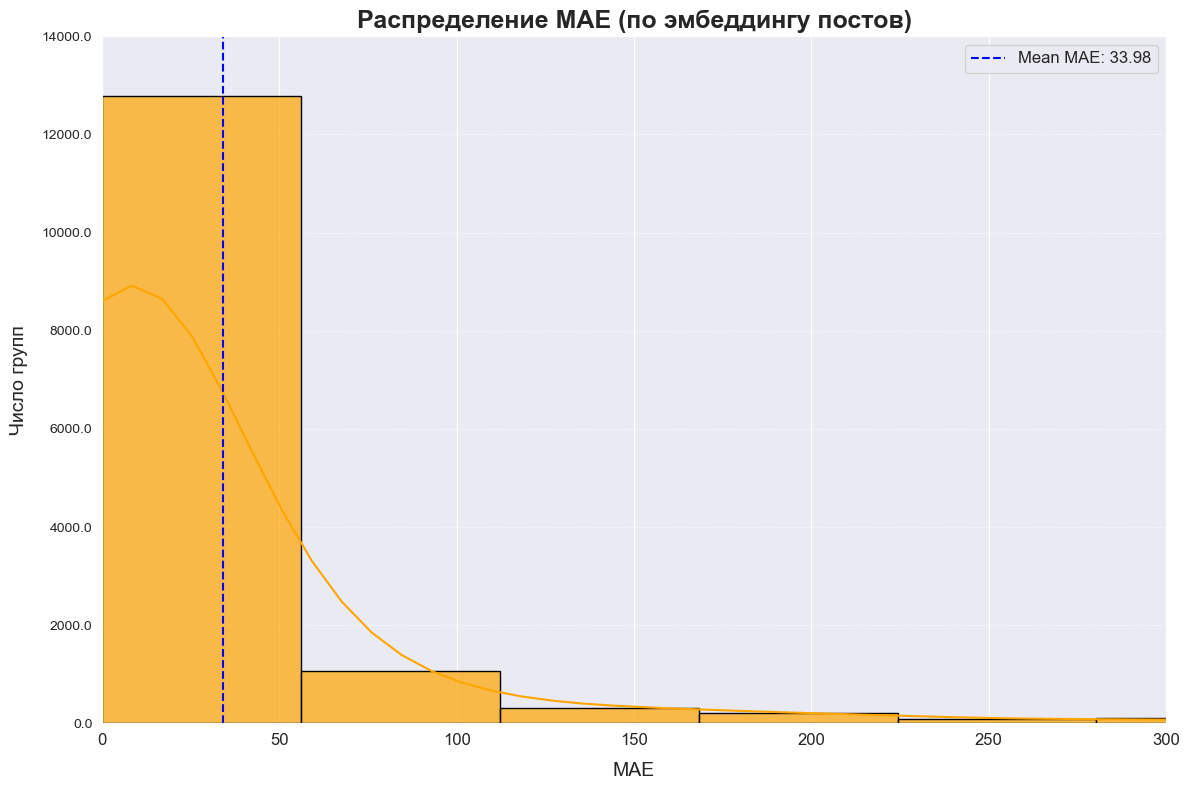

In [82]:
from matplotlib import pyplot as plt
import seaborn as sns

# Улучшенный график распределения MAE с ограничением по оси X
plt.figure(figsize=(12, 8))
sns.histplot(results_df['MAE'], kde=True, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.title('Распределение MAE (по эмбеддингу постов)', fontsize=18, fontweight='bold')
plt.xlabel('MAE', fontsize=14, labelpad=10)
plt.ylabel('Число групп', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 300)  # Ограничение по оси X до 500
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Среднее значение MAE
mean_mae = results_df['MAE'].mean()
plt.axvline(mean_mae, color='blue', linestyle='--', label=f'Mean MAE: {mean_mae:.2f}')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Очистили от выбросов

In [ ]:
# После очистки выбросов
results_df_cleaned = results_df[
    (results_df['MAE'] <= results_df['MAE'].quantile(0.95))
]
results_df_cleaned

In [24]:
# Средние значения после очистки
mean_mae_cleaned = results_df_cleaned['MAE'].mean()

print(f"Среднее MAE после очистки: {mean_mae_cleaned:.4f}")

Среднее MAE после очистки: 15.9013


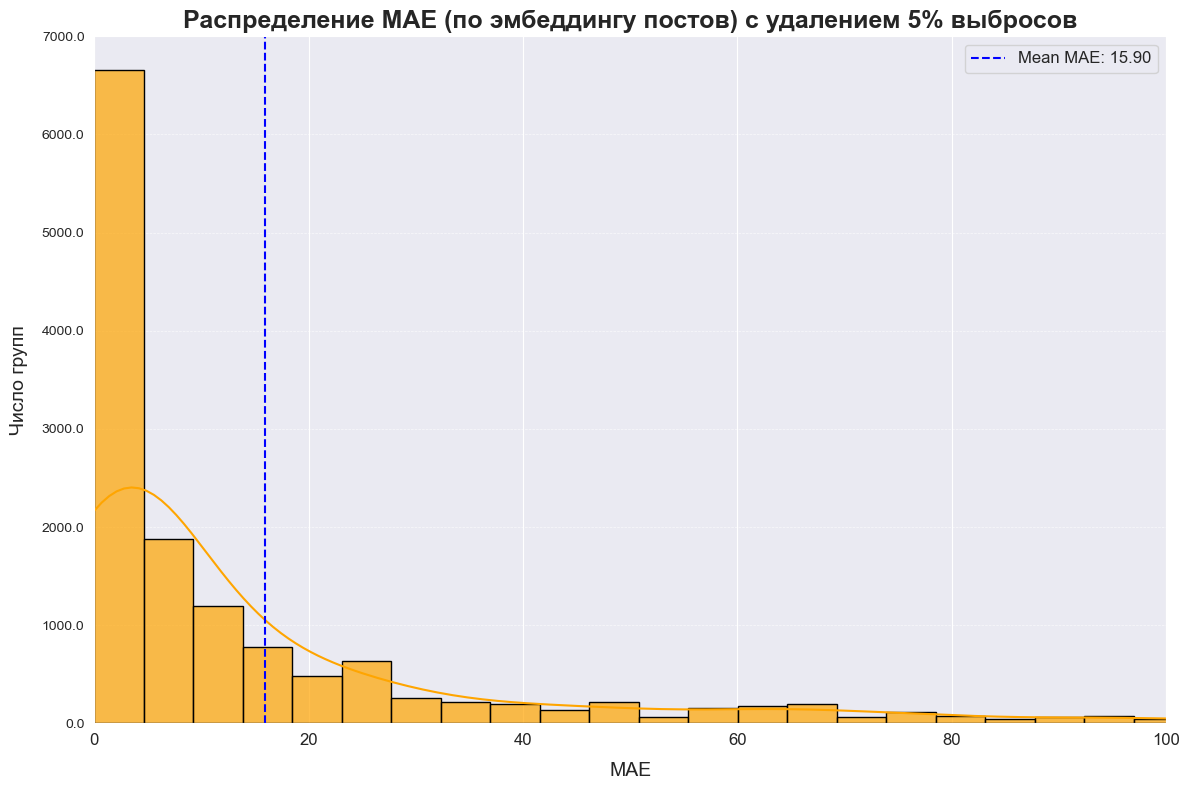

In [71]:
# Улучшенный график распределения MAE с ограничением по оси X
plt.figure(figsize=(12, 8))
sns.histplot(results_df_cleaned['MAE'], kde=True, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.title('Распределение MAE (по эмбеддингу постов) с удалением 5 % выбросов', fontsize=18, fontweight='bold')
plt.xlabel('MAE', fontsize=14, labelpad=10)
plt.ylabel('Число групп', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 80)  # Ограничение по оси X до 500
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Среднее значение MAE
mean_mae = results_df_cleaned['MAE'].mean()
plt.axvline(mean_mae, color='blue', linestyle='--', label=f'Mean MAE: {mean_mae:.2f}')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Использование эмбеддинга постов + весов Жакарда

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from collections import OrderedDict


def parse_embeddings(embedding_str):
    return np.fromstring(embedding_str.strip('[]'), sep=' ')


matrix_file = 'D:/PychramProjects/SNA_project/jaccard_matrix.txt'
matrix = pd.read_csv(matrix_file, header=None, delim_whitespace=True)

ids_file = 'D:/PychramProjects/SNA_project/ids.txt'
with open(ids_file, 'r') as f:
    ids = f.read().split()
matrix.columns = ids
matrix.index = ids

# j = matrix[str(13457639)]


df = pd.read_csv("D:/PychramProjects/SNA_project/posts_embeddings_cleaned.csv")
df['post_embedding'] = df['post_embedding'].apply(parse_embeddings)
print(df)

groups = df['group_id'].unique()
group_mse = {}
group_mae = {}
models = {}

rf_params = OrderedDict([
    ('max_depth', 30),
    ('max_features', 'sqrt'),
    ('min_samples_leaf', 8),
    ('min_samples_split', 16),
    ('n_estimators', 195)
])

group_stats = df.groupby('group_id')['likes'].agg(['mean', 'median'])

for group in groups:
    group_df = df[df['group_id'] == group]

    if len(group_df) < 100:
        continue

    # group_mean_likes = group_df['group_id'].map(group_stats['mean'])
    # y = group_df['likes'] / group_mean_likes
    # y.fillna(0, inplace=True)

    X = group_df['post_embedding'].tolist()

    y = group_df['likes']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)

    rf = RandomForestRegressor(**rf_params, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    group_mse[group] = mse
    group_mae[group] = mae
    models[group] = rf


m_l = list(models.keys())


def weighted_prediction(group, X_test, threshold=0.02):
    weights = matrix[str(group)]
    valid_weights = {other_group: weight for other_group, weight in weights.items() if
                     (weight > threshold and weight < 1.0 and int(other_group) in m_l)}
    total_weight = sum(valid_weights.values())

    weighted_preds = 0
    for other_group, weight in valid_weights.items():
        weighted_preds += weight * models[int(other_group)].predict(X_test)

    weighted_preds += models[group].predict(X_test) * (1 - total_weight)

    return weighted_preds


for group in groups:
    group_df = df[df['group_id'] == group]

    if len(group_df) < 100:
        continue

    # group_mean_likes = group_df['group_id'].map(group_stats['mean'])
    # y = group_df['likes'] / group_mean_likes
    # y.fillna(0, inplace=True)

    X = group_df['post_embedding'].tolist()

    y = group_df['likes']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)

    y_pred = weighted_prediction(group, X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    if group_mse[group] > mse:
        group_mse[group] = mse
    if group_mae[group] > mae:
        group_mae[group] = mae

    print(f'WEIGHTED group {group}, mae {mae}')

print(np.mean(list(group_mae.values())))


results_df = pd.DataFrame({
    'Group': list(group_mae.keys()),
    'MAE': list(group_mae.values())
})

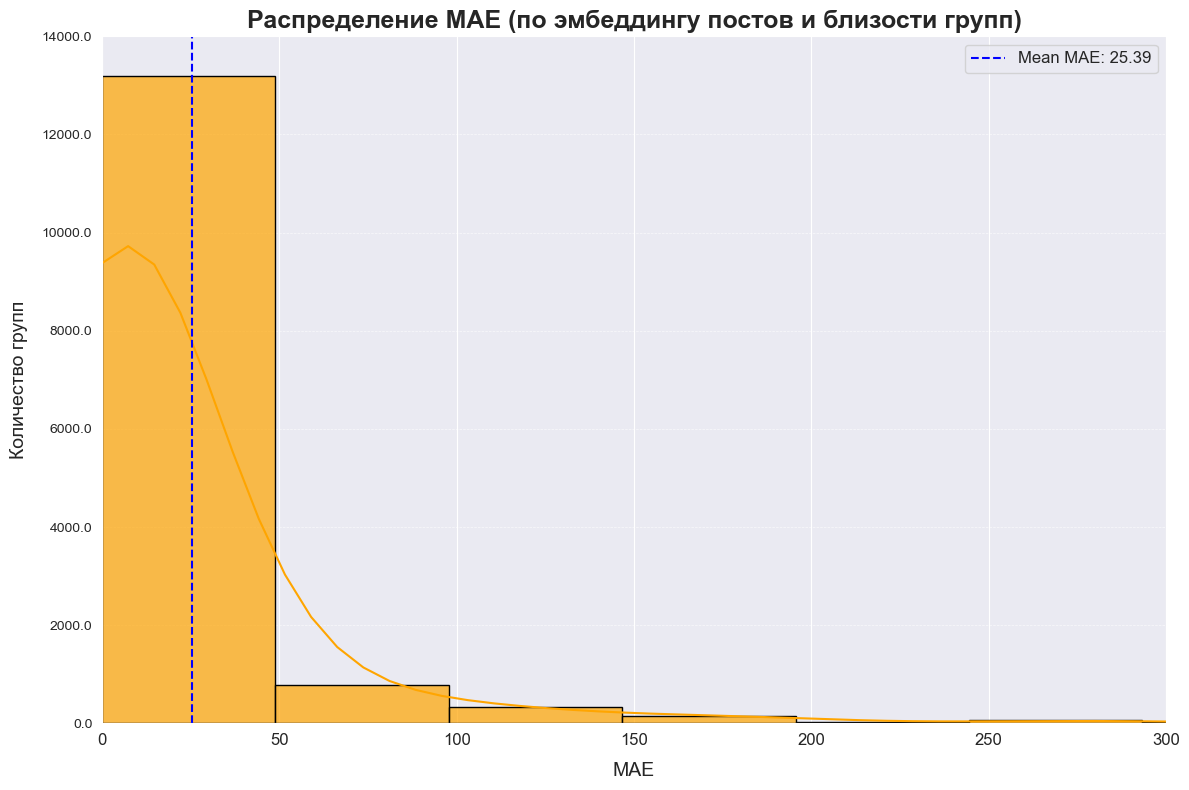

In [70]:
from matplotlib import pyplot as plt
import seaborn as sns

# Улучшенный график распределения MAE с ограничением по оси X
plt.figure(figsize=(12, 8))
sns.histplot(results_df['MAE'], kde=True, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.title('Распределение MAE (по эмбеддингу постов и близости групп)', fontsize=18, fontweight='bold')
plt.xlabel('MAE', fontsize=14, labelpad=10)
plt.ylabel('Количество групп', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 300)  # Ограничение по оси X до 500
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Среднее значение MAE
mean_mae = results_df['MAE'].mean()
plt.axvline(mean_mae, color='blue', linestyle='--', label=f'Mean MAE: {mean_mae:.2f}')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Взвешенное использование моделей 

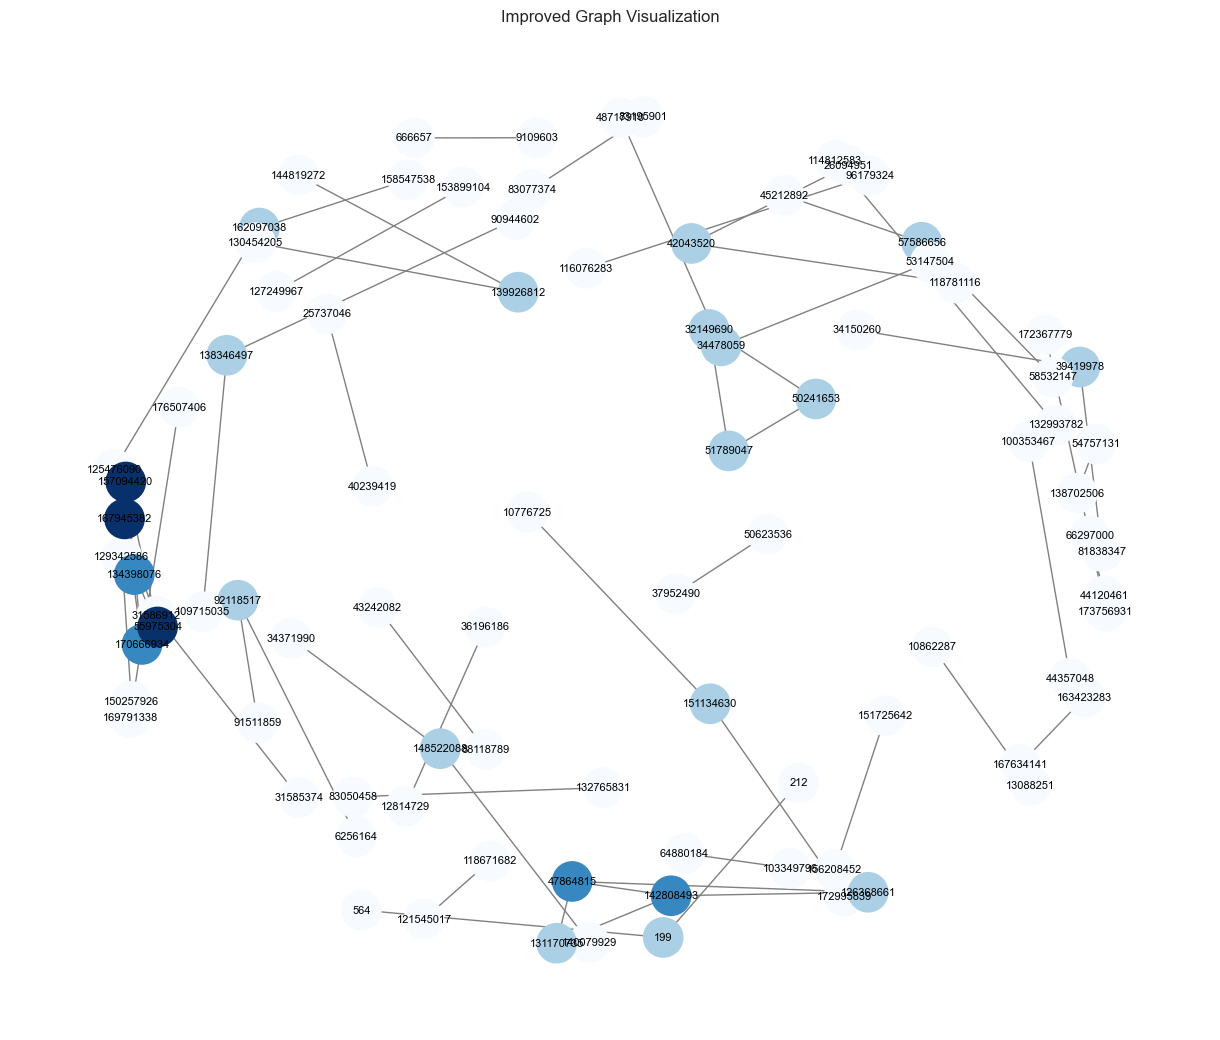

In [3]:
import networkx as nx


def read_jaccard_matrix(file_path):
    with open(file_path, 'r') as f:
        matrix = []
        for line in f:
            row = list(map(float, line.strip().split()))
            matrix.append(row)
    return matrix
def read_ids(file_path):
    with open(file_path, 'r') as f:
        ids = []
        for line in f:
            row = line.strip().split()
            ids.extend(row)
    return ids
def build_graph_from_jaccard(matrix, ids):
    G = nx.Graph()
    for i in range(len(matrix)):
        for j in range(i + 1, len(matrix)):  # Используем только верхний треугольник
            if matrix[i][j] > 0.1:
                G.add_edge(ids[i], ids[j], weight=matrix[i][j])
    return G
def visualize_graph(G):
    pos = nx.spring_layout(G, k=0.3)  # Увеличенная разрядка между узлами
    node_colors = [G.degree(n) for n in G.nodes()]  # Цвет узлов по их степени

    plt.figure(figsize=(12, 10))  # Увеличенный размер графика
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        cmap=plt.cm.Blues,
        node_size=800,
        edge_color='gray',
        font_size=8
    )
    plt.title("Improved Graph Visualization")
    plt.show()
input_file = "D:/PychramProjects/SNA_project/jaccard_matrix.txt"
ids_file = "D:/PychramProjects/SNA_project/ids.txt"
jaccard_matrix = read_jaccard_matrix(input_file)
ids = read_ids(ids_file)
graph = build_graph_from_jaccard(jaccard_matrix, ids)
visualize_graph(graph)    

In [4]:
def parse_embeddings(embedding_str):
    return np.fromstring(embedding_str.strip('[]'), sep=' ')

In [24]:
for i in [0.1*_ for _ in range(11)]:
    alpha = i  # Степень влияния голосов моделей-экспертов
    df = pd.read_csv("posts_embeddings_cleaned.csv")
    df['post_embedding'] = df['post_embedding'].apply(parse_embeddings)
    groups = df['group_id'].unique()
    group_mae = {}
    
    rf_params = OrderedDict([
        ('max_depth', 30),
        ('max_features', 'sqrt'),
        ('min_samples_leaf', 8),
        ('min_samples_split', 16),
        ('n_estimators', 195)
    ])
    group_stats = df.groupby('group_id')['likes'].agg(['mean', 'median'])
    models = {}
    Xs_test = {}
    ys_test = {}
    
    # Обучаем модели на группах
    for i, group in enumerate(graph.nodes): 
        group_df = df[df['group_id'] == int(group)]
        if len(group_df) < 100:
            continue
        X = group_df['post_embedding'].tolist()
        y = group_df['likes']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train = np.vstack(X_train)
        X_test = np.vstack(X_test)
        rf = RandomForestRegressor(**rf_params, random_state=42)
        rf.fit(X_train, y_train)
        models[int(group)] = rf
        ys_test[i] = y_test
        Xs_test[i] = X_test
    # Предсказываем отклик на пост в группе, учитывая обученные модели соседних нод
    for i, group in enumerate(graph.nodes):
        group_df = df[df['group_id'] == int(group)]
        if len(group_df) < 100:
            continue
        model = models[int(group)]
        sum_w = 0
        sum_pred = 0
        n_experts = 0
        for nbr, ddict in graph.adj[str(group)].items():
            if int(nbr) not in models:
                continue
            sum_pred += models[int(nbr)].predict(Xs_test[i]) * ddict['weight']
            sum_w += ddict['weight']
            n_experts += 1
        if sum_w == 0:
            sum_pred += models[int(group)].predict(Xs_test[i])
        else: 
            sum_pred /= sum_w
            sum_pred /= n_experts
            sum_pred *= alpha
            sum_pred += models[int(group)].predict(Xs_test[i]) * (1-alpha)
        mae = mean_absolute_error(ys_test[i], sum_pred)
        group_mae[group] = mae
        print(f'Group {group} - MAE: {group_mae[group]}')
    
    print(alpha, np.mean(list(group_mae.values())))


0.0 15.82317113394785
0.1 15.807152016225421
0.2 15.926111356088313
0.30000000000000004 16.147024262587916
0.4 16.51369621778347
0.5 16.996905093069124
0.6000000000000001 17.641298262864566
0.7000000000000001 18.475839353330223
0.8 19.526286364295608
0.9 20.786338926717672
1.0 22.109508775408983


In [ ]:
alpha = 0.1 # Степень влияния голосов моделей-экспертов
df = pd.read_csv("D:/PychramProjects/SNA_project/posts_embeddings_cleaned.csv")
df['post_embedding'] = df['post_embedding'].apply(parse_embeddings)
groups = df['group_id'].unique()
group_mae = {}

rf_params = OrderedDict([
    ('max_depth', 30),
    ('max_features', 'sqrt'),
    ('min_samples_leaf', 8),
    ('min_samples_split', 16),
    ('n_estimators', 195)
])
group_stats = df.groupby('group_id')['likes'].agg(['mean', 'median'])
models = {}
Xs_test = {}
ys_test = {}

# Обучаем модели на группах
for i, group in enumerate(graph.nodes): 
    group_df = df[df['group_id'] == int(group)]
    if len(group_df) < 100:
        continue
    X = group_df['post_embedding'].tolist()
    y = group_df['likes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)
    rf = RandomForestRegressor(**rf_params, random_state=42)
    rf.fit(X_train, y_train)
    models[int(group)] = rf
    ys_test[i] = y_test
    Xs_test[i] = X_test
# Предсказываем отклик на пост в группе, учитывая обученные модели соседних нод
for i, group in enumerate(graph.nodes): 
    group_df = df[df['group_id'] == int(group)]
    if len(group_df) < 100:
        continue
    model = models[int(group)]
    sum_w = 0
    sum_pred = 0
    n_experts = 0
    for nbr, ddict in graph.adj[str(group)].items():
        if int(nbr) not in models:
            continue
        sum_pred += models[int(nbr)].predict(Xs_test[i]) * ddict['weight']
        sum_w += ddict['weight']
        n_experts += 1
    if sum_w == 0:
        sum_pred += models[int(group)].predict(Xs_test[i])
    else: 
        sum_pred /= sum_w
        sum_pred /= n_experts
        sum_pred *= alpha
        sum_pred += models[int(group)].predict(Xs_test[i]) * (1-alpha)
    mae = mean_absolute_error(ys_test[i], sum_pred)
    group_mae[group] = mae
    print(f'Group {group} - MAE: {group_mae[group]}')
    
# Создание DataFrame из результатов
results_df = pd.DataFrame({
    'Group': list(group_mae.keys()),
    'MAE': list(group_mae.values())
})

In [74]:
np.mean(list(group_mae.values()))

15.807152016225421

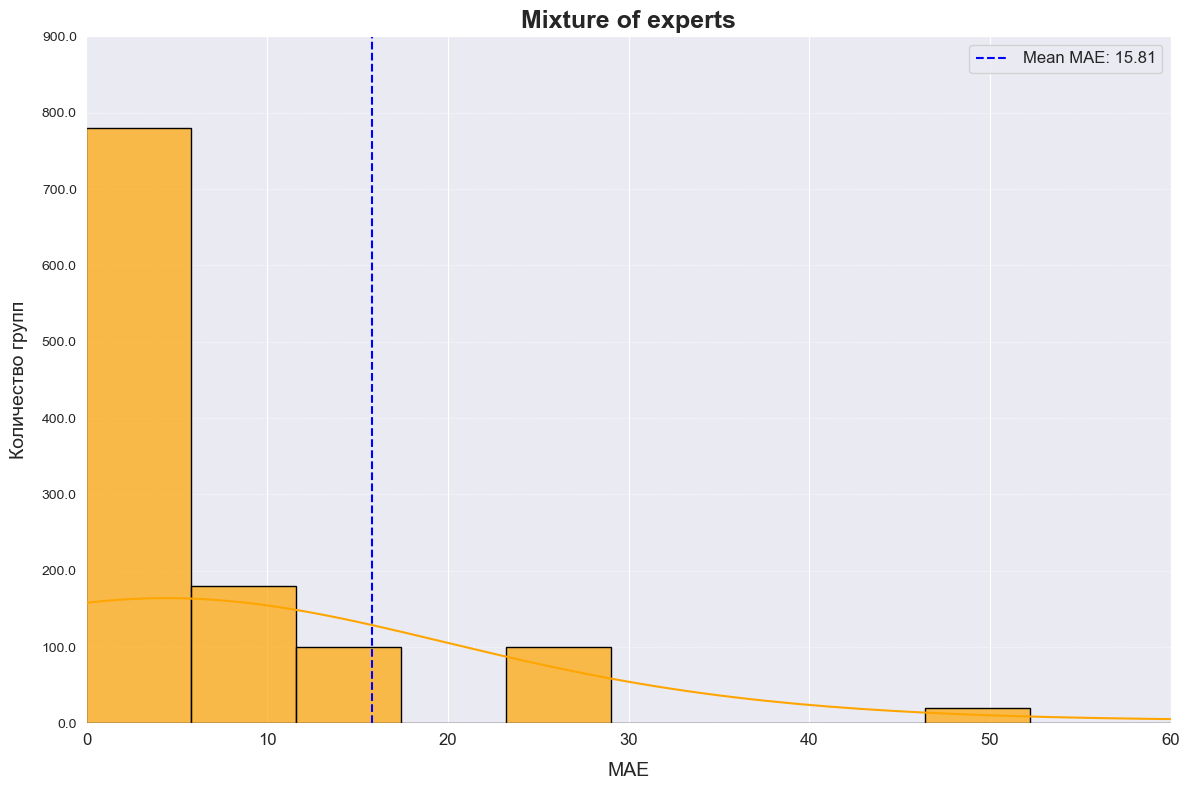

In [78]:
from matplotlib import pyplot as plt
import seaborn as sns

# Улучшенный график распределения MAE с ограничением по оси X
plt.figure(figsize=(12, 8))
sns.histplot(results_df['MAE'], kde=True, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.title('Mixture of experts', fontsize=18, fontweight='bold')
plt.xlabel('MAE', fontsize=14, labelpad=10)
plt.ylabel('Количество групп', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 100)  # Ограничение по оси X до 500
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Среднее значение MAE
mean_mae = results_df['MAE'].mean()
plt.axvline(mean_mae, color='blue', linestyle='--', label=f'Mean MAE: {mean_mae:.2f}')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()